In [1]:
# The line `# !pip install --upgrade -q numpy numba polars lightgbm tensorflow-addons` is a command that installs or upgrades several Python packages.
# !pip install --upgrade -q numpy numba polars lightgbm tensorflow-addons

In [2]:
import pandas as pd
import polars as pl
import numpy as np
from tqdm import tqdm
import gc
import json
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import gc
import os
import sys
sys.path.append('..')

from src import metric_fast
import joblib
import time
import importlib
importlib.reload(metric_fast)

2023-12-14 11:20:40.721750: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports 

<module 'src.metric_fast' from '/home/sleep-kaggle/kaggle_final_solution/../src/metric_fast.py'>

In [4]:
class cfg:
    samp_freq=1
    gaussian_overlay_len = 60
    std_dev_num = 2400
    ver='fm-v20-final'

In [ ]:
settings_json = json.load(open('../settings.json', 'r'))
print(settings_json)

for k,v in settings_json.items():
    setattr(cfg, k, v)
    
print(cfg.__dict__)

In [ ]:
%%time
train_events = pl.read_ipc(os.path.join(cfg.processed_data_path, 'train_events.ipc'))

In [5]:
splits_df = train_events[['series_id']].unique(maintain_order=True)
splits_df = splits_df.to_pandas()

for n_splits in [5, 7, 10]:
    folds = KFold(n_splits, shuffle=True, random_state=55125)

    splits_df[f'{n_splits}_fold'] = 0
    for i, (trn_idx, val_idx) in enumerate(folds.split(splits_df['series_id'], splits_df['series_id'])):
        
        splits_df.loc[val_idx, f'{n_splits}_fold'] = i+1
                                       
    
splits_df = pl.DataFrame(splits_df)             

In [6]:
def load_data(directory):
    X_s = []
    y_s = []
    series_ids = []

    for filename in tqdm(os.listdir(directory)):
        if filename.endswith('_X.npy'):
            series_id = filename.split('_X.npy')[0]
            X = np.load(os.path.join(directory, filename))
            y = np.load(os.path.join(directory, f'{series_id}_y.npy'))

            X_s.append(X)
            y_s.append(y)
            series_ids.append(series_id)

    return X_s, y_s, series_ids

In [7]:
def normalize_y(y):
    
    for i in range(y.shape[1]):
        
        mean = y[:,i].mean()
        std = y[:,i].std()
        y[:,i] = (y[:,i]-mean)/(std+1e-16)
    
    return y

In [8]:
def split_and_pad(X, y=None, split_length=1440, stride=1440):
    """
    Splits and pads the arrays X and y using a sliding window.

    Parameters:
    - X (np.array): Array with shape (timesteps, features)
    - y (np.array): Array with shape (timesteps, 2)
    - split_length (int): Desired timestep length for the resulting arrays.
    - stride (int): Step size for sliding window.

    Returns:
    - List of arrays for X and y, each with shape (split_length, features)
    """
    
    if y is not None and len(X) != len(y):
        raise ValueError("X and y should have the same number of timesteps.")
    
    timesteps, features = X.shape
    
    # Create empty lists to store split segments
    X_splits = []
    y_splits = []
    starts = []
    
    # Use sliding window to extract segments
    
    for start in range(0, timesteps, stride):
        end = start + split_length
        if end <= timesteps:
            starts.append(start)
            X_splits.append(X[start:end].copy())
            if y is not None:
                y_splits.append(y[start:end].copy())
        else:
            # If the segment is shorter than split_length, pad it
            starts.append(start)
            padding_length = end - timesteps
            X_segment_padded = np.pad(X[start:], ((0, padding_length), (0, 0)), mode='constant', constant_values=-9)
            X_splits.append(X_segment_padded)
            
            if y is not None:
                y_segment_padded = np.pad(y[start:], ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
                y_splits.append(y_segment_padded)
                
            break
            
            
    if y is not None:
        return X_splits, y_splits, starts
    
    return X_splits, starts



class SleepDataset:
    
    def __init__(self, X_s, y_s=None, series_ids=None, samp_freq=None, remove_no_dets=True, is_train=False, split_factor=1, norm_params=None):
        
        self.split_len = (24*60*12) // cfg.samp_freq
        self.split_strides = self.split_len
        self.remove_no_dets = remove_no_dets
        self.is_train = is_train

        print(f'Using a split len of {self.split_len}')
        self.create_dataset(X_s, y_s, series_ids)

        if self.is_train:
            self.norm_params = self.calculate_norm_params()
        else:
            if norm_params is None:
                raise ValueError("Normalization parameters must be provided for non-training data.")
            self.norm_params = norm_params

        self.normalize_data()

    def calculate_norm_params(self):
        mean = np.mean(self.X, axis=(0, 1))
        std = np.std(self.X, axis=(0, 1))
        return {'mean': mean, 'std': std}

    def normalize_data(self):
        self.X = (self.X - self.norm_params['mean']) / (1e-6 + self.norm_params['std'])
        
        
    def create_dataset(self, X_s, y_s=None, series_ids=None):
        X_s_splits, y_s_splits, series_splits, starts_splits = [], [], [], []

        for i in tqdm(range(len(X_s))):
            x_splits, starts = split_and_pad(X_s[i].copy(), split_length = self.split_len, stride=self.split_strides)
            X_s_splits.extend(x_splits)
            starts_splits.extend(starts)

            if y_s is not None:
                _, y_splits, _ = split_and_pad(X_s[i].copy(), y_s[i].copy(), split_length=self.split_len, stride=self.split_strides)
                y_s_splits.extend(y_splits)

            if series_ids is not None:
                series_splits.extend([series_ids[i] for _ in range(len(x_splits))])
            
        self.X = np.array(X_s_splits)
        self.starts_splits = np.array(starts_splits)
        
        if y_s is not None:
            self.y = np.array(y_s_splits)

            if self.remove_no_dets:
                fltr = (self.y[:, :, 1].sum(axis=1) + self.y[:, :, 0].sum(axis=1)) != 0
                self.X = self.X[fltr]
                self.y = self.y[fltr]
                if series_ids is not None:
                    self.series_ids = np.array(series_splits)[fltr]
                else:
                    self.series_ids = None
            
            self.y = np.array([normalize_y(yts) for yts in self.y])

        else:
            self.y = None

        if series_ids is not None:
            if not hasattr(self, 'series_ids'):
                self.series_ids = np.array(series_splits)
            print(f'X: {self.X.shape}, y: {self.y.shape if self.y is not None else "Not provided"}, series_ids: {self.series_ids.shape}')
        else:
            print(f'X: {self.X.shape}, y: {self.y.shape if self.y is not None else "Not provided"}')

In [9]:
def nms_nikhil(preds_orig, k_orig=125, max_thresh=0.05, max_count=1000):
    
    preds=preds_orig.copy()

    count = 0
    base=6.75
    
    k = k_orig
    prev_max = None

    scores = []
    indices = []
    
    while True:
            
        curr_max_idx = np.argmax(preds)
        curr_max = preds[curr_max_idx] 
        
        if (curr_max < max_thresh) or count > max_count:
            break
        
        indices.append(curr_max_idx)
        scores.append(curr_max)
        
        preds[curr_max_idx] = 0
        
        supress_rates = np.logspace(start=0, stop=1, num=k, base=base)/base

        preds[max(curr_max_idx-k, 0):curr_max_idx] *= supress_rates[:min(k, curr_max_idx-0)][::-1]
        preds[curr_max_idx+1:min(curr_max_idx+k+1, preds.shape[0])] *= supress_rates[:min(k, preds.shape[0]-curr_max_idx-1)]

        prev_max = curr_max
        
        count += 1
        
    return indices, scores

def get_actual_preds(val_preds, val_series_ids, val_steps, type_):
    times = []
    series_ids = []
    scores = []
    scores_y = []
    
    for i in np.arange(len(val_preds)):
        
        vp_i = val_preds[i]
        ser_id = val_series_ids[i]
        
        col_index = 0 if type_ == "onset" else 1
        other_col_index = 1 if type_ == "onset" else 0
        
        preds = vp_i[:, col_index]
        preds_other = vp_i[:, other_col_index]

        height_thresh = 0.05
        
        peaks, peak_scores = nms_nikhil(preds)

        times.extend(val_steps[i][peaks])
        scores.extend(list(peak_scores))
        series_ids.extend([ser_id] * len(peaks))

    return np.array(series_ids), np.array(times), np.array(scores)


def post_process_preds(val_events_df, val_preds, val_series_ids, val_starts_splits, samp_freq, get_score=False):
    
#     val_steps = np.concatenate([val_starts_splits[idx] + np.arange(len(val_preds[idx])) for idx in range(val_preds.shape[0])])

    val_res = []
    
    prev_ser_id = None
    
    res_steps = []
    res_preds = []
    res_series_ids = []
    
    start = 0
    while start < len(val_preds):
        
        end = start+1
        while end < len(val_preds) and val_series_ids[end] == val_series_ids[start]:
            end += 1
            
        preds = val_preds[start:end]
        
        steps = np.concatenate([val_starts_splits[idx] + np.arange(len(val_preds[idx])) for idx in range(start, end)])
        preds = preds.reshape((preds.shape[0]*preds.shape[1]), 2)
        
        res_preds.append(preds)
        res_steps.append(steps)
        res_series_ids.append(val_series_ids[start])
        
        start=end
        
        
#     print(len(res_series_ids), len(res_steps), len(res_preds))

    series_ids_onsets, onsets,  scores_onsets = get_actual_preds(res_preds, res_series_ids, res_steps, 'onset')
    series_ids_wakeups, wakeups,  scores_wakeups =get_actual_preds(res_preds, res_series_ids, res_steps, 'wakeup')
    
    
    onset_preds = pl.DataFrame().with_columns([pl.Series(series_ids_onsets).alias('series_id'),
                                           pl.Series(onsets).cast(pl.Int64).alias('step'),
                                           pl.lit('onset').alias('event'),
                                           pl.Series(scores_onsets).alias('score')])

    wakeup_preds = pl.DataFrame().with_columns([pl.Series(series_ids_wakeups).alias('series_id'),
                                               pl.Series(wakeups).cast(pl.Int64).cast(pl.Int64).alias('step'),
                                               pl.lit('wakeup').alias('event'),
                                               pl.Series(scores_wakeups).alias('score')])
    
    val_preds_df = pl.concat([onset_preds, wakeup_preds]).sort(by=['series_id', 'step'])
    
    if get_score:
        toleranaces = {'onset': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],'wakeup': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]}
        comp_score = metric_fast.comp_scorer(
        val_events_df,
        val_preds_df,
        tolerances = toleranaces,
        )
        return comp_score
    
    else:
        return val_preds_df

In [10]:
def calculate_exponential_lr(start_lr, end_lr, num_steps, decay_rate=None):
    """
    Calculate the exponentially decreasing learning rates.

    Parameters:
    start_lr (float): Initial learning rate.
    end_lr (float): Final learning rate.
    num_steps (int): Total number of steps over which the learning rate should decay.
    decay_rate (float): Decay rate per step. If None, it will be computed based on start_lr, end_lr, and num_steps.

    Returns:
    list: A list containing the learning rate for each step.
    """
    if decay_rate is None:
        # Calculate decay rate based on the start_lr, end_lr, and num_steps
        decay_rate = (end_lr / start_lr) ** (1 / (num_steps - 1))

    learning_rates = [start_lr * (decay_rate ** step) for step in range(num_steps)]
    return learning_rates



In [11]:
class IntervalEvaluation(tf.keras.callbacks.Callback):
    def __init__(self, val_ds, val_events_df, samp_freq, n_steps, start_lr, end_lr):

        super(tf.keras.callbacks.Callback, self).__init__()
        self.val_ds = val_ds
        self.val_events_df = val_events_df
        self.samp_freq = samp_freq
        
        warmup_pct_steps = 0.25
        warmup_steps = int(n_steps * warmup_pct_steps)
        self.learning_rates = [start_lr] * (warmup_steps) + calculate_exponential_lr(start_lr, end_lr, n_steps-warmup_steps)
        self.best_score = -np.inf
        self.best_model = None
        self.step_count=0

    def on_epoch_begin(self, epoch, logs={}):

        self.start_time = time.time()
        
        if epoch == 0:
            self.first_epoch_start_time = self.start_time
        
    def on_train_batch_begin(self, batch, logs=None):
        if self.step_count < len(self.learning_rates):

            tf.keras.backend.set_value(self.model.optimizer.lr, self.learning_rates[self.step_count])
            self.curr_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        self.step_count += 1
    
    def on_epoch_end(self, epoch, logs={}):

        val_preds = self.model.predict(self.val_ds.X, batch_size=8, verbose=0)[:, :, :2]
        val_score = post_process_preds(self.val_events_df, val_preds, self.val_ds.series_ids, self.val_ds.starts_splits, self.samp_freq, get_score=True)
        
        if val_score > self.best_score:
            self.best_score = val_score
            self.best_model = tf.keras.models.clone_model(self.model)
            self.best_model.set_weights(self.model.get_weights()) 
        
        total_time = round(time.time() - self.start_time, 2)
        total_seconds_till_now = round(time.time() - self.first_epoch_start_time, 0)
        
        print(f"Epoch: {epoch:03d} curr_lr: {self.curr_lr:.1e} - train_loss: {logs['loss']:.04f} - val_loss: {logs['val_loss']:.04f} val_score: {val_score:.03f}  best_val_score: {self.best_score:.03f}  last_epoch t={total_time:.02f}s, total_time_elapsed t={total_seconds_till_now}s")
        

In [12]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):

    # MultiHead Attention
    x = tfa.layers.MultiHeadAttention(
        head_size=head_size,
        num_heads=num_heads,
        use_projection_bias=True,
        dropout=dropout
    )([inputs, inputs, inputs])

    # Residual connection with LayerNormalization and Scaling
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + inputs) * (0.5 ** 0.5)
    
    # Feed Forward Part
    ff = tf.keras.layers.Dense(ff_dim, activation='relu')(x)
    # ff = tf.keras.layers.Dropout(dropout)(ff)
    ff = tf.keras.layers.Dense(inputs.shape[-1])(ff)
    # ff = tf.keras.layers.Dropout(dropout)(ff)
    
    # Residual connection with LayerNormalization and Scaling for FFN
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + ff) * (0.5 ** 0.5)

    return x

In [13]:
def custom_mce_loss(y_true, y_pred):
    # Clip the ground truth and predictions to the range (-100, 100)
    y_true_clipped = tf.clip_by_value(y_true, -100, 100)
    y_pred_clipped = tf.clip_by_value(y_pred, -100, 100)

    # Calculate the mean cubed error
    loss = tf.reduce_mean(tf.abs(y_true_clipped - y_pred_clipped) ** 3)
    return loss

In [14]:
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv1D(num_filters, 8, padding="same")(inputs)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv1D(num_filters, 8, padding="same")(x)
    x = tf.keras.layers.ReLU()(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    return x, p

def decoder_block(inputs, concat_tensors, num_filters):
    x = tf.keras.layers.Conv1DTranspose(num_filters, 4, strides=2, padding="same")(inputs)
    i = len(concat_tensors)-1
    for concat_tensor in concat_tensors:
        concat_tensor_max = tf.keras.layers.MaxPool1D(pool_size=2**i)(concat_tensor)
        x = tf.keras.layers.Concatenate()([x, concat_tensor_max])
        i -= 1
        
    x = conv_block(x, num_filters)
    return x

def get_model(input_shape, num_blocks=4):
    inputs = tf.keras.layers.Input(input_shape)
    x = inputs
    
    orig_n_channels = x.shape[-1]
    
    x_t = []
    n_split_fact = 4
    
    
    for i in range(x.shape[-1]):
        x_sp = tf.reshape(x[:, :, i], (-1, x.shape[1]//n_split_fact, n_split_fact))
        
        if i < orig_n_channels:
        
            # Calculating mean, max, and standard deviation
            mean = tf.reduce_mean(x_sp, axis=-1, keepdims=True)
            max_val = tf.reduce_max(x_sp, axis=-1, keepdims=True)
            std_dev = tf.math.reduce_std(x_sp, axis=-1, keepdims=True)
            min_val = tf.reduce_min(x_sp, axis=-1, keepdims=True)

            x_sp = tf.keras.layers.Concatenate()([x_sp, mean, max_val, std_dev, min_val])
        
        x_sp = tf.keras.layers.Dense(n_split_fact*16, activation='relu')(x_sp)
        
        x_t.append(x_sp)
        
    
    x_c1d = tf.keras.layers.Conv1D(64, kernel_size=12, strides=n_split_fact, padding="same")(x)
    x_c1d = tf.keras.layers.ReLU()(x_c1d)

    x = tf.keras.layers.Concatenate()(x_t + [x_c1d])# tf.reshape(x, (-1, -1, 3))
    
    # Initial filter size
    fsz = 64
    
    # Lists to hold the encoder and pooling outputs
    encoder_outputs = []
    pooling_outputs = []
    
    # Encoder
    for i in range(num_blocks):
        if i == 0:
            # First block receives the model input
            enc_out, pool_out = encoder_block(x, fsz * (2 ** i))
        else:
            # Subsequent blocks receive the pooling output of the previous block
            enc_out, pool_out = encoder_block(pooling_outputs[-1], fsz * (2 ** i))
        
        if i == 0:
            pool_out_copy = pool_out
            encoder_out_copy = enc_out
            
        else:
            pool_out_mp = tf.keras.layers.MaxPooling1D(pool_size=2**i)(pool_out_copy)
            encoder_out_mp = tf.keras.layers.MaxPooling1D(pool_size=2**i)(encoder_out_copy)
            
            pool_out = tf.keras.layers.Concatenate()([pool_out, pool_out_mp])
            enc_out = tf.keras.layers.Concatenate()([enc_out, encoder_out_mp])
        
        
        encoder_outputs.append(enc_out)
        pooling_outputs.append(pool_out)
    
    # Bottleneck
    bottleneck = conv_block(pooling_outputs[-1], fsz * (2 ** num_blocks))
    
    
    def gru_conv(x):
        x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(x.shape[-1]//4, return_sequences=True))(x)
        for i in range(1):
            x_conv = tf.keras.layers.Conv1D(x.shape[-1], kernel_size=(4,), padding='same', activation='relu')(x)
            x = tf.keras.layers.Dense(x.shape[-1], activation='relu')(x_conv)

        return x
    
    for _ in range(1):
        bottleneck = transformer_encoder(bottleneck, head_size=16, num_heads=8, ff_dim=256, dropout=0)

    bottleneck = gru_conv(bottleneck)

    decoder_input = bottleneck
    for i in range(num_blocks - 1, -1, -1):
        decoder_output = decoder_block(decoder_input, encoder_outputs[:i+1], fsz * (2 ** i))
        decoder_input = decoder_output
    
    # Output Layer
    x = tf.keras.layers.Conv1D(2*n_split_fact, 1, padding="same", activation="linear")(decoder_output)
    x = tf.reshape(x, shape=(-1, x.shape[1]*n_split_fact, 2))
    
    outputs = x
    
    model = tf.keras.models.Model(inputs, outputs)
    model.compile(optimizer=tfa.optimizers.AdamW(weight_decay=1e-4), loss=custom_mce_loss)
    
    return model

# Usage:
input_shape = (17280, 32)  # replace with your input shape
num_blocks = 4  # specify the number of encoder/decoder blocks
model = get_model(input_shape, num_blocks)
model.count_params()

2023-12-14 11:20:43.079098: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-12-14 11:20:43.199956: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46413 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:23:00.0, compute capability: 8.9
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


36630024

In [15]:
model.output.shape

TensorShape([None, 17280, 2])

In [16]:
class model_cfg:
    n_epochs = 14
    batch_size = 8
    start_lr = 6e-5
    end_lr = 2e-5

In [17]:
n_folds = 10
fold_run_order = list(np.arange(1, n_folds+1))

val_preds_lst = []
val_series_lst = []
val_starts_splits_lst = []

val_y_lst = []
models_lst = []
val_scores = []

model_dct = {}

for fold_num in fold_run_order:
    
    X_s, y_s, series_ids = load_data(cfg.processed_data_path)
    

    print(f'\n\n\n-----------Starting fold: {fold_num}-----------\n\n\n')
    
    series_ids_val = splits_df.filter(pl.col(f'{n_folds}_fold') == fold_num)['series_id'].to_numpy()

    val_idxs = [series_ids.index(s) for s in series_ids_val]
    trn_idxs = np.setdiff1d(np.arange(len(series_ids)), val_idxs)
    
    print(f'Using {len(trn_idxs)} series for training and {len(val_idxs)} series for validation')

    X_s_trn, y_s_trn, series_ids_trn = [X_s[i] for i in trn_idxs], [y_s[i] for i in trn_idxs], [series_ids[i] for i in trn_idxs]
    X_s_val, y_s_val, series_ids_val = [X_s[i] for i in val_idxs], [y_s[i] for i in val_idxs], [series_ids[i] for i in val_idxs]

    trn_ds = SleepDataset(X_s_trn, y_s_trn, series_ids_trn, cfg.samp_freq, remove_no_dets=False, is_train=True)
    norm_params = trn_ds.norm_params
    model_dct[fold_num] = norm_params
    
    val_ds = SleepDataset(X_s_val, y_s_val, series_ids_val, cfg.samp_freq, remove_no_dets=False, is_train=False, norm_params=norm_params)

    del X_s_trn, y_s_trn,  X_s_val, y_s_val, series_ids_trn, X_s, y_s, series_ids
    _ = gc.collect()


    model = get_model(trn_ds.X.shape[1:])
    
    print(f'Total model parameters: {model.count_params()}')

    val_events_df = train_events.filter(pl.col('series_id').is_in(series_ids_val))
    inter_eval = IntervalEvaluation(val_ds, val_events_df, cfg.samp_freq, (trn_ds.X.shape[0]//model_cfg.batch_size)*model_cfg.n_epochs, model_cfg.start_lr, model_cfg.end_lr)
    
    model.fit(trn_ds.X, trn_ds.y,
          epochs=model_cfg.n_epochs,
          batch_size=model_cfg.batch_size,
          callbacks=[inter_eval],
          verbose=1,
          validation_data=(val_ds.X, val_ds.y))
    
    
    
    last_loss = model.history.history['val_loss'][-1]
    print(f'Model finished with val loss: {last_loss}')
    
    model = inter_eval.best_model
    val_preds = model.predict(val_ds.X)
    
    val_score = post_process_preds(val_events_df, val_preds, val_ds.series_ids, val_ds.starts_splits, cfg.samp_freq, get_score=True)
    print(f'Val Score: {val_score}')
    
    val_scores.append(val_score)
    
    val_y_lst.append(val_ds.y)
    val_preds_lst.append(val_preds)
    val_series_lst.append(val_ds.series_ids)
    val_starts_splits_lst.append(val_ds.starts_splits)
    
    tf.keras.models.save_model(model, os.path.join(cfg.output_dir, cfg.ver, f'tf_model_fold_{fold_num}.h5'))
    
    del trn_ds, val_ds, model, inter_eval
    _ = gc.collect()

avg_val_score, std_val_score = np.mean(val_scores), np.std(val_scores)
print(f'Avg val score: {avg_val_score} and std val score: {std_val_score}')

100%|██████████| 529/529 [00:04<00:00, 119.05it/s]





-----------Starting fold: 1-----------



Using 237 series for training and 27 series for validation
Using a split len of 17280


100%|██████████| 237/237 [00:14<00:00, 16.83it/s]


X: (6508, 17280, 32), y: (6508, 17280, 2), series_ids: (6508,)
Using a split len of 17280


100%|██████████| 27/27 [00:00<00:00, 67.40it/s]


X: (696, 17280, 32), y: (696, 17280, 2), series_ids: (696,)
Total model parameters: 36630024
Epoch 1/14


2023-12-14 11:22:11.438232: I tensorflow/stream_executor/cuda/cuda_blas.cc:1633] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-14 11:22:11.464558: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700


814/814 [==============================] - 79s 87ms/step - loss: 4.2365 - val_loss: 3.3259
Epoch 2/14
814/814 [==============================] - 66s 81ms/step - loss: 3.6141 - val_loss: 3.3394
Epoch 3/14
814/814 [==============================] - 66s 81ms/step - loss: 3.5292 - val_loss: 3.2376
Epoch 4/14
814/814 [==============================] - 63s 77ms/step - loss: 3.4725 - val_loss: 3.3848
Epoch 5/14
814/814 [==============================] - 64s 79ms/step - loss: 3.4149 - val_loss: 3.3272
Epoch 6/14
814/814 [==============================] - 65s 80ms/step - loss: 3.3860 - val_loss: 3.1186
Epoch 7/14
814/814 [==============================] - 65s 80ms/step - loss: 3.3557 - val_loss: 3.2693
Epoch 8/14
814/814 [==============================] - 68s 83ms/step - loss: 3.3223 - val_loss: 3.1043
Epoch 9/14
814/814 [==============================] - 64s 78ms/step - loss: 3.3011 - val_loss: 3.0926
Epoch 10/14
814/814 [==============================] - 63s 78ms/step - loss: 3.2658 - val_los

100%|██████████| 529/529 [00:05<00:00, 95.68it/s] 





-----------Starting fold: 2-----------



Using 237 series for training and 27 series for validation
Using a split len of 17280


100%|██████████| 237/237 [00:13<00:00, 18.11it/s]


X: (6506, 17280, 32), y: (6506, 17280, 2), series_ids: (6506,)
Using a split len of 17280


100%|██████████| 27/27 [00:00<00:00, 27.58it/s]


X: (698, 17280, 32), y: (698, 17280, 2), series_ids: (698,)
Total model parameters: 36630024
Epoch 1/14
814/814 [==============================] - 78s 86ms/step - loss: 4.2188 - val_loss: 3.5369
Epoch 2/14
814/814 [==============================] - 66s 82ms/step - loss: 3.6344 - val_loss: 3.4403
Epoch 3/14
814/814 [==============================] - 65s 79ms/step - loss: 3.5043 - val_loss: 3.5846
Epoch 4/14
814/814 [==============================] - 66s 81ms/step - loss: 3.4785 - val_loss: 3.4251
Epoch 5/14
814/814 [==============================] - 68s 83ms/step - loss: 3.4215 - val_loss: 3.3718
Epoch 6/14
814/814 [==============================] - 68s 84ms/step - loss: 3.3831 - val_loss: 3.3354
Epoch 7/14
814/814 [==============================] - 68s 84ms/step - loss: 3.3480 - val_loss: 3.2971
Epoch 8/14
814/814 [==============================] - 67s 82ms/step - loss: 3.3269 - val_loss: 3.2795
Epoch 9/14
814/814 [==============================] - 66s 81ms/step - loss: 3.2999 - val_lo

100%|██████████| 529/529 [00:05<00:00, 93.32it/s] 





-----------Starting fold: 3-----------



Using 237 series for training and 27 series for validation
Using a split len of 17280


100%|██████████| 237/237 [00:10<00:00, 23.07it/s]


X: (6438, 17280, 32), y: (6438, 17280, 2), series_ids: (6438,)
Using a split len of 17280


100%|██████████| 27/27 [00:00<00:00, 33.03it/s]


X: (766, 17280, 32), y: (766, 17280, 2), series_ids: (766,)
Total model parameters: 36630024
Epoch 1/14
805/805 [==============================] - 79s 90ms/step - loss: 4.3073 - val_loss: 3.6976
Epoch 2/14
805/805 [==============================] - 68s 85ms/step - loss: 3.6274 - val_loss: 3.5764
Epoch 3/14
805/805 [==============================] - 67s 83ms/step - loss: 3.5248 - val_loss: 3.7643
Epoch 4/14
805/805 [==============================] - 68s 84ms/step - loss: 3.4648 - val_loss: 3.5406
Epoch 5/14
805/805 [==============================] - 65s 81ms/step - loss: 3.4049 - val_loss: 3.6074
Epoch 6/14
805/805 [==============================] - 66s 82ms/step - loss: 3.3634 - val_loss: 3.5569
Epoch 7/14
805/805 [==============================] - 69s 86ms/step - loss: 3.3198 - val_loss: 3.4951
Epoch 8/14
805/805 [==============================] - 66s 82ms/step - loss: 3.3024 - val_loss: 3.8044
Epoch 9/14
805/805 [==============================] - 68s 85ms/step - loss: 3.2850 - val_lo

100%|██████████| 529/529 [00:05<00:00, 104.79it/s]





-----------Starting fold: 4-----------



Using 237 series for training and 27 series for validation
Using a split len of 17280


100%|██████████| 237/237 [00:10<00:00, 23.26it/s]


X: (6382, 17280, 32), y: (6382, 17280, 2), series_ids: (6382,)
Using a split len of 17280


100%|██████████| 27/27 [00:01<00:00, 22.70it/s]


X: (822, 17280, 32), y: (822, 17280, 2), series_ids: (822,)
Total model parameters: 36630024
Epoch 1/14
798/798 [==============================] - 81s 92ms/step - loss: 4.2574 - val_loss: 4.0319
Epoch 2/14
798/798 [==============================] - 69s 86ms/step - loss: 3.6002 - val_loss: 3.8715
Epoch 3/14
798/798 [==============================] - 69s 86ms/step - loss: 3.4853 - val_loss: 3.7834
Epoch 4/14
798/798 [==============================] - 66s 83ms/step - loss: 3.4645 - val_loss: 3.8841
Epoch 5/14
798/798 [==============================] - 69s 86ms/step - loss: 3.3803 - val_loss: 3.8142
Epoch 6/14
798/798 [==============================] - 67s 84ms/step - loss: 3.3337 - val_loss: 3.7905
Epoch 7/14
798/798 [==============================] - 69s 86ms/step - loss: 3.3079 - val_loss: 3.6768
Epoch 8/14
798/798 [==============================] - 67s 84ms/step - loss: 3.2754 - val_loss: 3.7213
Epoch 9/14
798/798 [==============================] - 69s 86ms/step - loss: 3.2485 - val_lo

100%|██████████| 529/529 [00:04<00:00, 109.20it/s]





-----------Starting fold: 5-----------



Using 238 series for training and 26 series for validation
Using a split len of 17280


100%|██████████| 238/238 [00:09<00:00, 25.82it/s]


X: (6434, 17280, 32), y: (6434, 17280, 2), series_ids: (6434,)
Using a split len of 17280


100%|██████████| 26/26 [00:00<00:00, 32.35it/s]


X: (770, 17280, 32), y: (770, 17280, 2), series_ids: (770,)
Total model parameters: 36630024
Epoch 1/14
805/805 [==============================] - 80s 92ms/step - loss: 4.3112 - val_loss: 3.5145
Epoch 2/14
805/805 [==============================] - 69s 85ms/step - loss: 3.6581 - val_loss: 3.2617
Epoch 3/14
805/805 [==============================] - 67s 83ms/step - loss: 3.5666 - val_loss: 3.3493
Epoch 4/14
805/805 [==============================] - 69s 86ms/step - loss: 3.4848 - val_loss: 3.4231
Epoch 5/14
805/805 [==============================] - 66s 83ms/step - loss: 3.4451 - val_loss: 3.2810
Epoch 6/14
805/805 [==============================] - 68s 85ms/step - loss: 3.4028 - val_loss: 3.1206
Epoch 7/14
805/805 [==============================] - 69s 86ms/step - loss: 3.3636 - val_loss: 3.1260
Epoch 8/14
805/805 [==============================] - 65s 81ms/step - loss: 3.3403 - val_loss: 3.1480
Epoch 9/14
805/805 [==============================] - 66s 82ms/step - loss: 3.3154 - val_lo

100%|██████████| 529/529 [00:05<00:00, 100.68it/s]





-----------Starting fold: 6-----------



Using 238 series for training and 26 series for validation
Using a split len of 17280


100%|██████████| 238/238 [00:10<00:00, 23.31it/s]


X: (6472, 17280, 32), y: (6472, 17280, 2), series_ids: (6472,)
Using a split len of 17280


100%|██████████| 26/26 [00:00<00:00, 33.99it/s]


X: (732, 17280, 32), y: (732, 17280, 2), series_ids: (732,)
Total model parameters: 36630024
Epoch 1/14
809/809 [==============================] - 71s 80ms/step - loss: 4.3250 - val_loss: 3.4169
Epoch 2/14
809/809 [==============================] - 62s 76ms/step - loss: 3.6556 - val_loss: 3.3625
Epoch 3/14
809/809 [==============================] - 59s 73ms/step - loss: 3.5590 - val_loss: 3.2505
Epoch 4/14
809/809 [==============================] - 59s 73ms/step - loss: 3.4806 - val_loss: 3.2053
Epoch 5/14
809/809 [==============================] - 59s 72ms/step - loss: 3.4371 - val_loss: 3.2626
Epoch 6/14
809/809 [==============================] - 60s 74ms/step - loss: 3.3985 - val_loss: 3.2604
Epoch 7/14
809/809 [==============================] - 61s 76ms/step - loss: 3.3674 - val_loss: 3.2110
Epoch 8/14
809/809 [==============================] - 59s 74ms/step - loss: 3.3442 - val_loss: 3.1194
Epoch 9/14
809/809 [==============================] - 60s 74ms/step - loss: 3.3175 - val_lo

100%|██████████| 529/529 [00:04<00:00, 109.00it/s]





-----------Starting fold: 7-----------



Using 238 series for training and 26 series for validation
Using a split len of 17280


100%|██████████| 238/238 [00:10<00:00, 21.85it/s]


X: (6533, 17280, 32), y: (6533, 17280, 2), series_ids: (6533,)
Using a split len of 17280


100%|██████████| 26/26 [00:00<00:00, 27.57it/s]


X: (671, 17280, 32), y: (671, 17280, 2), series_ids: (671,)
Total model parameters: 36630024
Epoch 1/14
817/817 [==============================] - 78s 87ms/step - loss: 4.3116 - val_loss: 3.7540
Epoch 2/14
817/817 [==============================] - 65s 80ms/step - loss: 3.6107 - val_loss: 3.5824
Epoch 3/14
817/817 [==============================] - 66s 80ms/step - loss: 3.5013 - val_loss: 3.4933
Epoch 4/14
817/817 [==============================] - 65s 80ms/step - loss: 3.4491 - val_loss: 3.4970
Epoch 5/14
817/817 [==============================] - 64s 79ms/step - loss: 3.3829 - val_loss: 3.4633
Epoch 6/14
817/817 [==============================] - 65s 79ms/step - loss: 3.3695 - val_loss: 3.5494
Epoch 7/14
817/817 [==============================] - 64s 78ms/step - loss: 3.3392 - val_loss: 3.6072
Epoch 8/14
817/817 [==============================] - 65s 80ms/step - loss: 3.3033 - val_loss: 3.7375
Epoch 9/14
817/817 [==============================] - 68s 83ms/step - loss: 3.2788 - val_lo

100%|██████████| 529/529 [00:04<00:00, 127.96it/s]





-----------Starting fold: 8-----------



Using 238 series for training and 26 series for validation
Using a split len of 17280


100%|██████████| 238/238 [00:09<00:00, 25.48it/s]


X: (6478, 17280, 32), y: (6478, 17280, 2), series_ids: (6478,)
Using a split len of 17280


100%|██████████| 26/26 [00:00<00:00, 29.03it/s]


X: (726, 17280, 32), y: (726, 17280, 2), series_ids: (726,)
Total model parameters: 36630024
Epoch 1/14
810/810 [==============================] - 79s 90ms/step - loss: 4.1204 - val_loss: 4.2012
Epoch 2/14
810/810 [==============================] - 67s 83ms/step - loss: 3.5640 - val_loss: 3.7737
Epoch 3/14
810/810 [==============================] - 66s 82ms/step - loss: 3.4744 - val_loss: 3.8030
Epoch 4/14
810/810 [==============================] - 68s 84ms/step - loss: 3.4312 - val_loss: 3.8762
Epoch 5/14
810/810 [==============================] - 68s 83ms/step - loss: 3.3809 - val_loss: 3.8834
Epoch 6/14
810/810 [==============================] - 66s 82ms/step - loss: 3.3284 - val_loss: 3.8367
Epoch 7/14
810/810 [==============================] - 65s 80ms/step - loss: 3.3016 - val_loss: 3.6612
Epoch 8/14
810/810 [==============================] - 69s 85ms/step - loss: 3.2883 - val_loss: 3.6743
Epoch 9/14
810/810 [==============================] - 67s 83ms/step - loss: 3.2531 - val_lo

100%|██████████| 529/529 [00:04<00:00, 111.20it/s]





-----------Starting fold: 9-----------



Using 238 series for training and 26 series for validation
Using a split len of 17280


100%|██████████| 238/238 [00:09<00:00, 24.89it/s]


X: (6545, 17280, 32), y: (6545, 17280, 2), series_ids: (6545,)
Using a split len of 17280


100%|██████████| 26/26 [00:00<00:00, 34.20it/s]


X: (659, 17280, 32), y: (659, 17280, 2), series_ids: (659,)
Total model parameters: 36630024
Epoch 1/14
819/819 [==============================] - 78s 87ms/step - loss: 4.3432 - val_loss: 3.9902
Epoch 2/14
819/819 [==============================] - 68s 83ms/step - loss: 3.6080 - val_loss: 3.8300
Epoch 3/14
819/819 [==============================] - 65s 79ms/step - loss: 3.4935 - val_loss: 3.7840
Epoch 4/14
819/819 [==============================] - 68s 83ms/step - loss: 3.4262 - val_loss: 3.6718
Epoch 5/14
819/819 [==============================] - 68s 83ms/step - loss: 3.3861 - val_loss: 3.6792
Epoch 6/14
819/819 [==============================] - 67s 82ms/step - loss: 3.3446 - val_loss: 3.6152
Epoch 7/14
819/819 [==============================] - 65s 79ms/step - loss: 3.3208 - val_loss: 3.7230
Epoch 8/14
819/819 [==============================] - 65s 79ms/step - loss: 3.2817 - val_loss: 3.8168
Epoch 9/14
819/819 [==============================] - 64s 78ms/step - loss: 3.2513 - val_lo

100%|██████████| 529/529 [00:05<00:00, 104.11it/s]





-----------Starting fold: 10-----------



Using 238 series for training and 26 series for validation
Using a split len of 17280


100%|██████████| 238/238 [00:10<00:00, 22.45it/s]


X: (6540, 17280, 32), y: (6540, 17280, 2), series_ids: (6540,)
Using a split len of 17280


100%|██████████| 26/26 [00:00<00:00, 34.66it/s]


X: (664, 17280, 32), y: (664, 17280, 2), series_ids: (664,)
Total model parameters: 36630024
Epoch 1/14
818/818 [==============================] - 78s 86ms/step - loss: 4.2497 - val_loss: 3.5067
Epoch 2/14
818/818 [==============================] - 67s 82ms/step - loss: 3.6427 - val_loss: 3.4584
Epoch 3/14
818/818 [==============================] - 66s 81ms/step - loss: 3.5296 - val_loss: 3.3690
Epoch 4/14
818/818 [==============================] - 66s 80ms/step - loss: 3.4833 - val_loss: 3.2919
Epoch 5/14
818/818 [==============================] - 66s 81ms/step - loss: 3.4370 - val_loss: 3.3910
Epoch 6/14
818/818 [==============================] - 67s 82ms/step - loss: 3.3928 - val_loss: 3.2308
Epoch 7/14
818/818 [==============================] - 67s 81ms/step - loss: 3.3508 - val_loss: 3.2275
Epoch 8/14
818/818 [==============================] - 65s 79ms/step - loss: 3.3279 - val_loss: 3.2596
Epoch 9/14
818/818 [==============================] - 68s 83ms/step - loss: 3.3011 - val_lo

###### series_ids_val

In [18]:
val_starts_splits_all = np.concatenate(val_starts_splits_lst)
val_preds_all = np.concatenate(val_preds_lst)
val_series_all = np.concatenate(val_series_lst)
val_y_all = np.concatenate(val_y_lst)

print(val_preds_all.shape, val_y_all.shape, val_series_all.shape)

(7204, 17280, 2) (7204, 17280, 2) (7204,)


In [19]:
# The code is creating a DataFrame `oof_preds_df` that contains the predicted values for the "onset" and "wakeup" columns.

res_steps = []
res_preds_onsets = []
res_preds_wakeups = []

res_series_ids = []

start = 0
while start < len(val_preds_all):
    
    end = start+1
    while end < len(val_preds_all) and val_series_all[end] == val_series_all[start]:
        end += 1
        
    preds = val_preds_all[start:end]
    
    steps = np.concatenate([val_starts_splits_all[idx] + np.arange(len(val_preds_all[idx])) for idx in range(start, end)])
    preds = preds.reshape((preds.shape[0]*preds.shape[1]), 2)
    
    res_preds_onsets.append(preds[:, 0])
    res_preds_wakeups.append(preds[:, 1])
    
    res_steps.append(steps)
    ser_id = val_series_all[start]
    
    res_series_ids.append([ser_id for _ in range(len(preds))])
    
    start=end
    
    
oof_preds_df = pl.DataFrame().with_columns([
    pl.Series(np.concatenate(res_series_ids)).alias('series_id'),
    pl.Series(np.concatenate(res_steps)).alias('step'),
    pl.Series(np.concatenate(res_preds_onsets)).alias('onset'),
    pl.Series(np.concatenate(res_preds_wakeups)).alias('wakeup')

])

train_series = pl.read_parquet(cfg.train_series_path)
print(train_series.shape)
train_series = train_series.filter(pl.col('series_id').is_in(list(np.unique(val_series_all))))
train_series = train_series.with_columns(pl.col('step').cast(pl.Int64))
print(train_series.shape)



print(oof_preds_df.shape)
oof_preds_df = train_series[['series_id', 'step']].join(oof_preds_df, on=['series_id', 'step'], how='left')
print(oof_preds_df.shape)

oof_preds_df.write_parquet(os.path.join(cfg.output_dir, cfg.ver, 'oof_preds.parquet'))

(127946340, 5)
(122539680, 5)
(124485120, 4)
(122539680, 4)


In [20]:
# !rm -r ../data_processed/{cfg.ver}

25e2b3dd9c3b


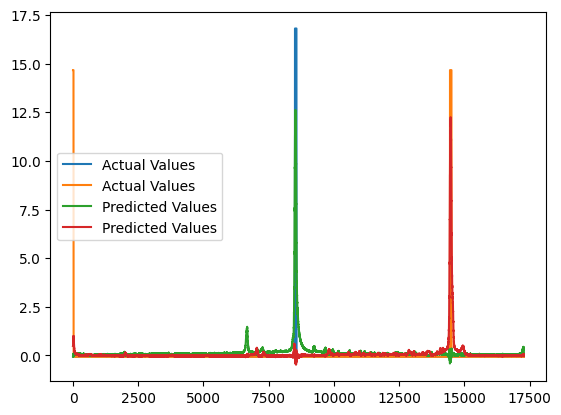

In [21]:
i = 2
# sid = val_series_all.filter(pl.col())
plt.plot(val_y_all[i], label="Actual Values")
print(val_series_all[i])

plt.plot(val_preds_all[i], label="Predicted Values")


plt.legend()
plt.show()

In [22]:
def nms_nikhil(preds_orig, k_orig=150, max_thresh=0.05, max_count=500):
    
    preds=preds_orig.copy()
    preds = np.convolve(preds, np.array([0.2, 0.6, 0.2]), mode='same')

    count = 0
    base=6.75
    
    k = k_orig
    prev_max = None

    scores = []
    indices = []
    
    while True:
            
        curr_max_idx = np.argmax(preds)
        curr_max = preds[curr_max_idx] 
        
        if (curr_max < max_thresh) or count > max_count:
            break
        
        indices.append(curr_max_idx)
        scores.append(curr_max)
        
        preds[curr_max_idx] = 0
        
        supress_rates = np.logspace(start=0, stop=1, num=k, base=base)/base
        supress_rates[:20] = 0
        # supress_rates[20:] += 0.1

        preds[max(curr_max_idx-k, 0):curr_max_idx] *= supress_rates[:min(k, curr_max_idx-0)][::-1]

        preds[curr_max_idx+1:min(curr_max_idx+k+1, preds.shape[0])] *= supress_rates[:min(k, preds.shape[0]-curr_max_idx-1)]

        prev_max = curr_max
        
        count += 1
        
    return indices, scores

def get_actual_preds(val_preds, val_series_ids, val_steps, type_):
    times = []
    series_ids = []
    scores = []
    scores_y = []
    
    for i in np.arange(len(val_preds)):
        
        vp_i = val_preds[i]
        ser_id = val_series_ids[i]
        
        col_index = 0 if type_ == "onset" else 1
        other_col_index = 1 if type_ == "onset" else 0
        
        preds = vp_i[:, col_index]
        preds_other = vp_i[:, other_col_index]

        height_thresh = 0.05
        
        peaks, peak_scores = nms_nikhil(preds)

        times.extend(val_steps[i][peaks])
        scores.extend(list(peak_scores))
        series_ids.extend([ser_id] * len(peaks))

    return np.array(series_ids), np.array(times), np.array(scores)




def post_process_preds(val_events_df, val_preds, val_series_ids, val_starts_splits, samp_freq, get_score=False):
    
#     val_steps = np.concatenate([val_starts_splits[idx] + np.arange(len(val_preds[idx])) for idx in range(val_preds.shape[0])])

    val_res = []
    
    prev_ser_id = None
    
    res_steps = []
    res_preds = []
    res_series_ids = []
    
    start = 0
    while start < len(val_preds):
        
        end = start+1
        while end < len(val_preds) and val_series_ids[end] == val_series_ids[start]:
            end += 1
            
        preds = val_preds[start:end]
        
        steps = np.concatenate([val_starts_splits[idx] + np.arange(len(val_preds[idx])) for idx in range(start, end)])
        preds = preds.reshape((preds.shape[0]*preds.shape[1]), 2)
        
        res_preds.append(preds)
        res_steps.append(steps)
        res_series_ids.append(val_series_ids[start])
        
        start=end
        
        
#     print(len(res_series_ids), len(res_steps), len(res_preds))

    series_ids_onsets, onsets,  scores_onsets = get_actual_preds(res_preds, res_series_ids, res_steps, 'onset')
    series_ids_wakeups, wakeups,  scores_wakeups =get_actual_preds(res_preds, res_series_ids, res_steps, 'wakeup')
    
    
    onset_preds = pl.DataFrame().with_columns([pl.Series(series_ids_onsets).alias('series_id'),
                                           pl.Series(onsets).cast(pl.Int64).alias('step'),
                                           pl.lit('onset').alias('event'),
                                           pl.Series(scores_onsets).alias('score')])

    wakeup_preds = pl.DataFrame().with_columns([pl.Series(series_ids_wakeups).alias('series_id'),
                                               pl.Series(wakeups).cast(pl.Int64).cast(pl.Int64).alias('step'),
                                               pl.lit('wakeup').alias('event'),
                                               pl.Series(scores_wakeups).alias('score')])
    
    val_preds_df = pl.concat([onset_preds, wakeup_preds]).sort(by=['series_id', 'step'])
    
    if get_score:
        toleranaces = {'onset': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],'wakeup': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]}
        comp_score = metric_fast.comp_scorer(
        val_events_df,
        val_preds_df,
        tolerances = toleranaces,
        )
        return comp_score
    
    else:
        return val_preds_df

In [23]:
%%time
scores = []

for fold_num in range(1, n_folds+1):
    
    test_ser_ids = list(np.unique(val_series_lst[fold_num-1]))


    val_events_df = train_events.filter(pl.col('series_id').is_in(test_ser_ids))
    score = post_process_preds(val_events_df,
                               val_preds_lst[fold_num-1],
                               val_series_lst[fold_num-1],
                               val_starts_splits_lst[fold_num-1],
                               cfg.samp_freq,
                               get_score=True)
    print(score)
    scores.append(score)
    
np.mean(scores), np.std(scores)

0.8444650558831941
0.8416758383803757
0.7230944421667282
0.8170324102230753
0.8322065516148098
0.8504343515800763
0.8522675854574908
0.8385581752914013
0.8032440013867315
0.8422204112717888
CPU times: user 29.7 s, sys: 37 s, total: 1min 6s
Wall time: 1min 5s


(0.8245198823255672, 0.03674090916266876)

In [24]:
val_preds_df = post_process_preds(val_events_df, val_preds_all, val_series_all, val_starts_splits_all, cfg.samp_freq, get_score=False)

In [25]:
def round_to_nearest_multiple(df, column_name='step'):
    df[column_name] = df[column_name].apply(lambda x: x+1 if x%12==0  else x)
    return df


In [26]:
val_preds_df = round_to_nearest_multiple(val_preds_df.to_pandas())
val_preds_df = pl.DataFrame(val_preds_df)

In [27]:
tolerances = {'onset': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],
               'wakeup': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]}

In [28]:
metric_fast.comp_scorer(train_events, val_preds_df, tolerances=tolerances)

0.814316353453655

In [29]:
val_preds_df.shape

(262222, 4)

In [30]:
preds_partitions  = val_preds_df.partition_by(by=['series_id'], maintain_order=True, as_dict=True)
events_partitions  = val_events_df.partition_by(by=['series_id'], maintain_order=True, as_dict=True)

tolerances = {'onset': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],
               'wakeup': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]}

scores_dict = {}
for ser_id in tqdm(events_partitions.keys()):
    scores_dict[ser_id] = metric_fast.comp_scorer(events_partitions[ser_id], preds_partitions[ser_id],
                                                  tolerances)
    

100%|██████████| 26/26 [00:05<00:00,  5.07it/s]


In [31]:
pd.Series(scores_dict).sort_values()

148471991ffb    0.450931
c535634d7dcd    0.463728
703b5efa9bc1    0.488174
fbf33b1a2c10    0.697022
35826366dfc7    0.747556
4ac356361be9    0.759743
ece2561f07e9    0.816578
9b9cd7b7af8c    0.818099
1319a1935f48    0.823714
0cd1e3d0ed95    0.836974
f88e18cb4100    0.868700
eef041dd50aa    0.869135
fcca183903b7    0.879574
ce85771a714c    0.883841
3be1545083b7    0.887776
137771d19ca2    0.891360
0ef7d94fde99    0.892744
8b159a98f485    0.914702
40dce6018935    0.916484
9ddd40f2cb36    0.920464
3df0da2e5966    0.925641
d8de352c2657    0.934613
927dd0c35dfd    0.936609
2f7504d0f426    0.948389
72ba4a8afff4    0.963179
c7d693f24684    0.970733
dtype: float64

In [32]:
cfg_attributes_dict = {k: v for k, v in cfg.__dict__.items() if not k.startswith('__') and not callable(v)}
joblib.dump(cfg_attributes_dict, os.path.join(cfg.output_dir, cfg.ver, 'cfg.pkl'))
joblib.dump(model_dct, os.path.join(cfg.output_dir, cfg.ver, 'model_dct.pkl'))

np.save(os.path.join(cfg.output_dir, cfg.ver, 'val_series_all.npy'), val_series_all)


val_preds_df.to_pandas().to_csv(os.path.join(cfg.output_dir, cfg.ver, 'val_preds_df.csv'), index=False)

np.save(os.path.join(cfg.output_dir, cfg.ver, 'val_preds_all.npy'), val_preds_all)
np.save(os.path.join(cfg.output_dir, cfg.ver, 'val_y_all.npy'), val_y_all)

In [33]:
import json

meta_json = {
  "title": f"sleep-model-{cfg.ver}",
  "id": f"nikhilmishradev/sleep-model-{cfg.ver}",
  "licenses": [
    {
      "name": "CC0-1.0"
    }
  ]
}

json.dump(meta_json, open(os.path.join(cfg.output_dir, cfg.ver, 'dataset-metadata.json'), 'w'))

In [34]:
# !rm -r ../outputs/vx/*
# !cp -r {os.path.join(cfg.output_dir, cfg.ver)}/* ../outputs/vx
# !rm ../outputs/vx/val_preds_all.npy ../outputs/vx/val_y_all.npy
# !pip install -q kaggle
# !kaggle datasets create -p ../outputs/vx

Skipping folder: .ipynb_checkpoints; use '--dir-mode' to upload folders
Starting upload for file cfg.pkl
100%|███████████████████████████████████████████| 119/119 [00:02<00:00, 49.1B/s]
Upload successful: cfg.pkl (119B)
Starting upload for file model_dct.pkl
100%|██████████████████████████████████████| 4.00k/4.00k [00:02<00:00, 1.98kB/s]
Upload successful: model_dct.pkl (4KB)
Starting upload for file oof_preds.parquet
100%|██████████████████████████████████████| 1.02G/1.02G [00:58<00:00, 18.6MB/s]
Upload successful: oof_preds.parquet (1GB)
Starting upload for file tf_model_fold_1.h5
100%|████████████████████████████████████████| 140M/140M [00:10<00:00, 14.1MB/s]
Upload successful: tf_model_fold_1.h5 (140MB)
Starting upload for file tf_model_fold_10.h5
100%|████████████████████████████████████████| 140M/140M [00:11<00:00, 13.0MB/s]
Upload successful: tf_model_fold_10.h5 (140MB)
Starting upload for file tf_model_fold_2.h5
100%|████████████████████████████████████████| 140M/140M [00:11<00

In [35]:
np.save(os.path.join(cfg.output_dir, cfg.ver, 'val_preds_all.npy'), val_preds_all)
np.save(os.path.join(cfg.output_dir, cfg.ver, 'val_y_all.npy'), val_y_all)

In [36]:
cfg.ver

'fm-v20-final'